# Modeling Text Data




You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning 

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score

In [241]:
data = pd.read_csv('Vision_Zero_Entry.csv')
df = data[['REQUESTTYPE','COMMENTS']]    # of obs: 8534
df = df.copy()

# Consolidating categories
# reduce to 14 categories in REQUESTTYPE
df.loc[df['REQUESTTYPE'].str.contains('Not enough time to cross'), 'REQUESTTYPE'] = "there's not enough time to cross the street"
df.loc[df['REQUESTTYPE'].str.contains('Bike facility issue'), 'REQUESTTYPE'] = "the roadway surface needs improvement"
df.loc[df['REQUESTTYPE'].str.contains('Hard to see'), 'REQUESTTYPE'] = "it’s hard to see"
df.loc[df['REQUESTTYPE'].str.contains('Sidewalk issue'), 'REQUESTTYPE'] = "sidewalks/ramps don't exist or need improvement"
df.loc[df['REQUESTTYPE'].str.contains('Speeding'), 'REQUESTTYPE'] = "people speed"
df.loc[df['REQUESTTYPE'].str.contains('Wait is too long'), 'REQUESTTYPE'] = 'the wait for the "Walk" signal is too long'
df.loc[df['REQUESTTYPE'].str.contains('Other issue'), 'REQUESTTYPE'] = 'of something that is not listed here'
df.loc[df['REQUESTTYPE'] =='people are not given enough time to cross the street', 'REQUESTTYPE'] = "there's not enough time to cross the street"
df.loc[df['REQUESTTYPE'] == 'it’s hard to see', 'REQUESTTYPE'] = 'it’s hard to see / low visibility'
df.loc[df['REQUESTTYPE'] == 'it’s hard for people to see each other', 'REQUESTTYPE'] = 'it’s hard to see / low visibility'
df.loc[df['REQUESTTYPE'] == 'people have to wait too long for the "Walk" signal', 'REQUESTTYPE'] = 'the wait for the "Walk" signal is too long'
df.loc[df['REQUESTTYPE'] == 'people have to cross too many lanes / too far', 'REQUESTTYPE'] = "it's too far / too many lanes to cross"
df.loc[df['REQUESTTYPE'] == 'there are no sidewalks or they need maintenance', 'REQUESTTYPE'] = "sidewalks/ramps don't exist or need improvement"
df.loc[df['REQUESTTYPE'] == 'the roadway surface needs maintenance', 'REQUESTTYPE'] = "the roadway surface needs improvement"
df.loc[df['REQUESTTYPE'] == 'there are no bike facilities or they need maintenance', 'REQUESTTYPE'] = "bike facilities don't exist or need improvement"

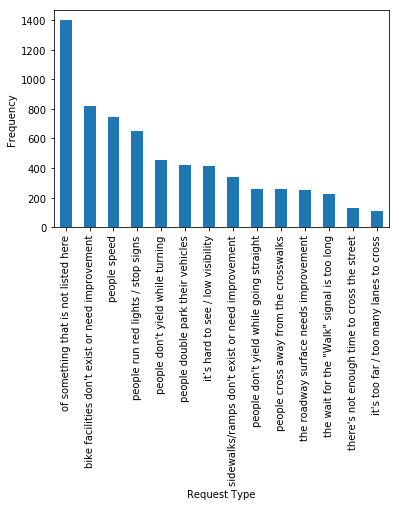

In [242]:
# drop missing comment
df = df.dropna(axis=0)
# Remove duplicate data points
df = df.drop_duplicates()
# Before shape: (8534, 2)
# After shape: (6457, 2)

# Visualize the class distribution
df_table = pd.crosstab(index=df['REQUESTTYPE'], columns="Frequency", )
df_table
df.REQUESTTYPE.value_counts().plot(kind='bar')
plt.xlabel('Request Type')
plt.ylabel('Frequency')
plt.show()

In [243]:
text = df['COMMENTS']
y = df['REQUESTTYPE']

In [244]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y.values.ravel())
#list(le.classes_)
#le.transform(["people speed"]) 
#list(le.inverse_transform([2, 2, 1]))

LabelEncoder()

# Task2 - Model 1 

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

In [245]:
from sklearn.model_selection import train_test_split
# split to test and train set
text_train, text_test, y_train, y_test = train_test_split(text, y, stratify=y, random_state=1)
print("X_train shape: {}".format(text_train.shape)) 
print("type of text_train: {}".format(type(text_train)))
# split train to sub and validation set

X_train shape: (4842,)
type of text_train: <class 'pandas.core.series.Series'>


In [246]:
from sklearn.feature_extraction.text import CountVectorizer 
vect = CountVectorizer()
X_train = vect.fit_transform(text_train.values.astype('U'))
X_test = vect.transform(text_test.values.astype('U'))

print("Vocabulary size: {}".format(len(vect.vocabulary_))) 
#print("Vocabulary content:\n {}".format(vect.vocabulary_))
class_name = np.array(df_table.index)
class_name
feature_names = np.array(vect.get_feature_names())
print(feature_names[:130])         # a lot numbers, represent time, speed, place
print(feature_names[2000:2020])
print(feature_names[::400])

Vocabulary size: 5761
['00' '00am' '02124' '10' '100' '1000' '1000s' '101' '1010' '109' '10am'
 '10x' '11' '114' '115' '1161' '11a' '12' '128' '13' '13th' '14' '15' '16'
 '17' '18' '19' '1979' '1a' '1asouth' '1st' '20' '200' '2000' '2009' '2014'
 '2015' '2016' '203' '20mph' '21' '22' '2201' '229' '24' '25' '250' '257'
 '25mph' '26' '27' '275' '2am' '2nd' '30' '300' '30mph' '311' '314' '32'
 '342' '35' '365' '39' '3a' '3ft' '3rd' '40' '40mi' '40mph' '426' '45'
 '473' '4pm' '4th' '50' '500' '501' '503' '50mph' '50s' '524' '544' '55'
 '564' '5am' '5min' '5pm' '5th' '60' '60mph' '65' '65mph' '66' '6am' '6pm'
 '70' '75' '7am' '7pm' '7th' '80' '802' '85' '88' '899' '8am' '8th' '90'
 '90º' '91' '93' '93n' '93s' '95' '98' '99' '9am' '_all' '_never_' 'aact'
 'aaron' 'abandon' 'abates' 'abide' 'abiding' 'ability' 'able' 'abot'
 'about']
['fenwood' 'ferrin' 'few' 'fewer' 'fews' 'fidelis' 'fiedler' 'field'
 'fields' 'fight' 'fighters' 'fighting' 'fights' 'figure' 'fill' 'filled'
 'filling' 'filter

In [201]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV().fit(X_train, y_train)
lr.C_
lr.score(X_test, y_test)

0.59628482972136221

In [202]:
from sklearn.metrics import f1_score
y_pred = lr.predict(X_test)
print("macro f1_score: {}".format(f1_score(y_test, y_pred,average='macro')))


macro f1_score: 0.5562934434217653


In [204]:
from sklearn.metrics import confusion_matrix
#Confusion Matrix without Normalization
C=confusion_matrix(y_test, y_pred)
pd.DataFrame(C , index = np.array(df_table.index), columns = np.array(df_table.index))


,bike facilities don't exist or need improvement,it's too far / too many lanes to cross,it’s hard to see / low visibility,of something that is not listed here,people cross away from the crosswalks,people don't yield while going straight,people don't yield while turning,people double park their vehicles,people run red lights / stop signs,people speed,sidewalks/ramps don't exist or need improvement,the roadway surface needs improvement,"the wait for the ""Walk"" signal is too long",there's not enough time to cross the street
bike facilities don't exist or need improvement,152,1,1,30,0,2,7,3,1,2,2,3,0,0
it's too far / too many lanes to cross,0,3,2,12,2,0,2,0,1,1,0,0,3,1
it’s hard to see / low visibility,2,0,59,28,1,0,0,2,3,6,1,1,0,0
of something that is not listed here,35,2,11,198,12,5,20,7,19,15,18,4,2,2
people cross away from the crosswalks,1,1,1,21,33,1,2,0,0,1,2,1,0,0
people don't yield while going straight,1,0,3,15,2,20,7,0,5,8,2,0,1,0
people don't yield while turning,6,0,4,27,3,5,53,0,11,4,0,0,0,0
people double park their vehicles,5,0,2,16,0,0,0,77,1,2,1,1,0,0
people run red lights / stop signs,3,0,2,24,0,2,4,0,120,6,0,0,1,0
people speed,8,0,9,26,3,3,4,0,7,123,2,0,1,0


In [205]:
#Confusion Matrix with Normalization
pd.DataFrame(C / C.astype(np.float).sum(axis=1) , index = np.array(df_table.index),
                          columns = np.array(df_table.index))


,bike facilities don't exist or need improvement,it's too far / too many lanes to cross,it’s hard to see / low visibility,of something that is not listed here,people cross away from the crosswalks,people don't yield while going straight,people don't yield while turning,people double park their vehicles,people run red lights / stop signs,people speed,sidewalks/ramps don't exist or need improvement,the roadway surface needs improvement,"the wait for the ""Walk"" signal is too long",there's not enough time to cross the street
bike facilities don't exist or need improvement,0.745098,0.037037,0.009709,0.085714,0.000000,0.031250,0.061947,0.028571,0.006173,0.010753,0.023529,0.048387,0.000000,0.000000
it's too far / too many lanes to cross,0.000000,0.111111,0.019417,0.034286,0.031250,0.000000,0.017699,0.000000,0.006173,0.005376,0.000000,0.000000,0.052632,0.030303
it’s hard to see / low visibility,0.009804,0.000000,0.572816,0.080000,0.015625,0.000000,0.000000,0.019048,0.018519,0.032258,0.011765,0.016129,0.000000,0.000000
of something that is not listed here,0.171569,0.074074,0.106796,0.565714,0.187500,0.078125,0.176991,0.066667,0.117284,0.080645,0.211765,0.064516,0.035088,0.060606
people cross away from the crosswalks,0.004902,0.037037,0.009709,0.060000,0.515625,0.015625,0.017699,0.000000,0.000000,0.005376,0.023529,0.016129,0.000000,0.000000
people don't yield while going straight,0.004902,0.000000,0.029126,0.042857,0.031250,0.312500,0.061947,0.000000,0.030864,0.043011,0.023529,0.000000,0.017544,0.000000
people don't yield while turning,0.029412,0.000000,0.038835,0.077143,0.046875,0.078125,0.469027,0.000000,0.067901,0.021505,0.000000,0.000000,0.000000,0.000000
people double park their vehicles,0.024510,0.000000,0.019417,0.045714,0.000000,0.000000,0.000000,0.733333,0.006173,0.010753,0.011765,0.016129,0.000000,0.000000
people run red lights / stop signs,0.014706,0.000000,0.019417,0.068571,0.000000,0.031250,0.035398,0.000000,0.740741,0.032258,0.000000,0.000000,0.017544,0.000000
people speed,0.039216,0.000000,0.087379,0.074286,0.046875,0.046875,0.035398,0.000000,0.043210,0.661290,0.023529,0.000000,0.017544,0.000000


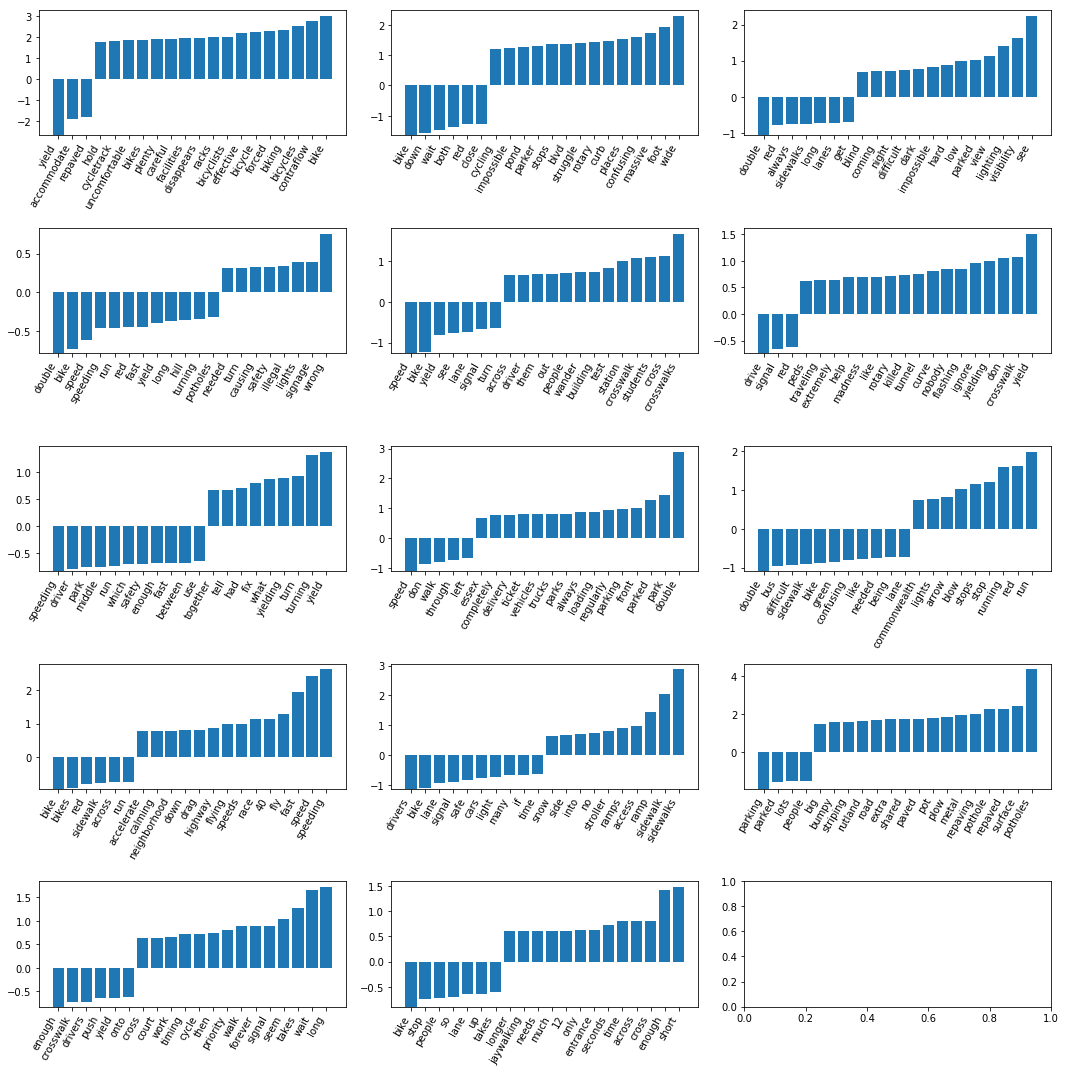

In [206]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")
    
feature_names = np.array(vect.get_feature_names())
n_components = 20
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
for ax, coef in zip(axes.ravel(), lr.coef_):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()
plt.show()

### Both the singular and plural forms are contained in the vocabulary as distinct words. These words have very closely related semantic meanings, and counting them as different words, corresponding to different features. Including both upper and lower cases. In the first important feature plot, 'bikes', 'bike' and 'bicycles' mean the same thing, and these words need to be combined. Most of numbers don't have any immediate semantic meaning, like 'to', 'so' and 'in' , and so need to be removed.

# Task3 - Model 2 

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

In [207]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

#pipe = make_pipeline(TfidfVectorizer(stop_words='english'), LogisticRegression())
#param_grid={'logisticregression__C': [10, 1, .1, .01],
#            'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,5), (2,3)],
#            'tfidfvectorizer__min_df': [1,2,3,4],
#            'tfidfvectorizer__analyzer': ['word', 'char']}

#grid = GridSearchCV(pipe, param_grid=param_grid, cv=5,scoring='f1_macro')
#grid.fit(text_train.values.astype('U'), y_train)
#print("grid best score: {}".format(grid.best_score_))
#print("grid best parameters: {}".format(grid.best_params_))


In [247]:
# use the best grid model
vect = TfidfVectorizer(stop_words='english', min_df = 2, ngram_range = (1,2), analyzer = 'word')
X_train = vect.fit_transform(text_train.values.astype('U'))
lr_grid = LogisticRegression(C=10).fit(X_train, y_train)
feature_names = np.array(vect.get_feature_names())

In [248]:
X_test = vect.transform(text_test.values.astype('U'))
y_pred1 = lr_grid.predict(X_test)
print(f1_score(y_test, y_pred1, average='macro'))

0.532923052889


# Task4 - Visualize Results

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

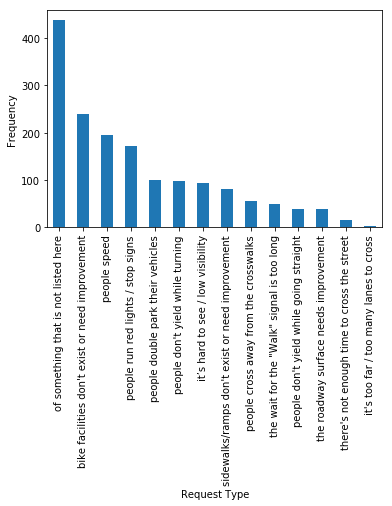

In [210]:
pd.DataFrame(y_pred1)[0].value_counts().plot(kind='bar')
plt.xlabel('Request Type')
plt.ylabel('Frequency')
plt.show()

In [211]:
# confusion matrix without normalizer
C1 = confusion_matrix(y_test, y_pred1)
pd.DataFrame(C1, index = np.array(df_table.index),
                          columns = np.array(df_table.index))
# C1 / C1.astype(np.float).sum(axis=1)

,bike facilities don't exist or need improvement,it's too far / too many lanes to cross,it’s hard to see / low visibility,of something that is not listed here,people cross away from the crosswalks,people don't yield while going straight,people don't yield while turning,people double park their vehicles,people run red lights / stop signs,people speed,sidewalks/ramps don't exist or need improvement,the roadway surface needs improvement,"the wait for the ""Walk"" signal is too long",there's not enough time to cross the street
bike facilities don't exist or need improvement,166,0,1,23,0,0,4,2,0,2,3,3,0,0
it's too far / too many lanes to cross,5,0,3,7,3,0,1,0,1,2,0,0,4,1
it’s hard to see / low visibility,2,0,55,29,1,2,2,3,3,6,0,0,0,0
of something that is not listed here,29,0,12,201,7,3,19,13,22,20,16,3,4,1
people cross away from the crosswalks,0,0,0,23,30,1,0,0,0,5,5,0,0,0
people don't yield while going straight,2,0,4,17,0,18,6,0,4,10,1,0,2,0
people don't yield while turning,5,0,5,25,1,9,52,0,11,5,0,0,0,0
people double park their vehicles,6,0,3,13,0,0,1,78,1,3,0,0,0,0
people run red lights / stop signs,1,0,4,23,0,1,3,1,119,8,0,0,2,0
people speed,7,0,5,26,2,5,4,0,6,127,2,0,2,0


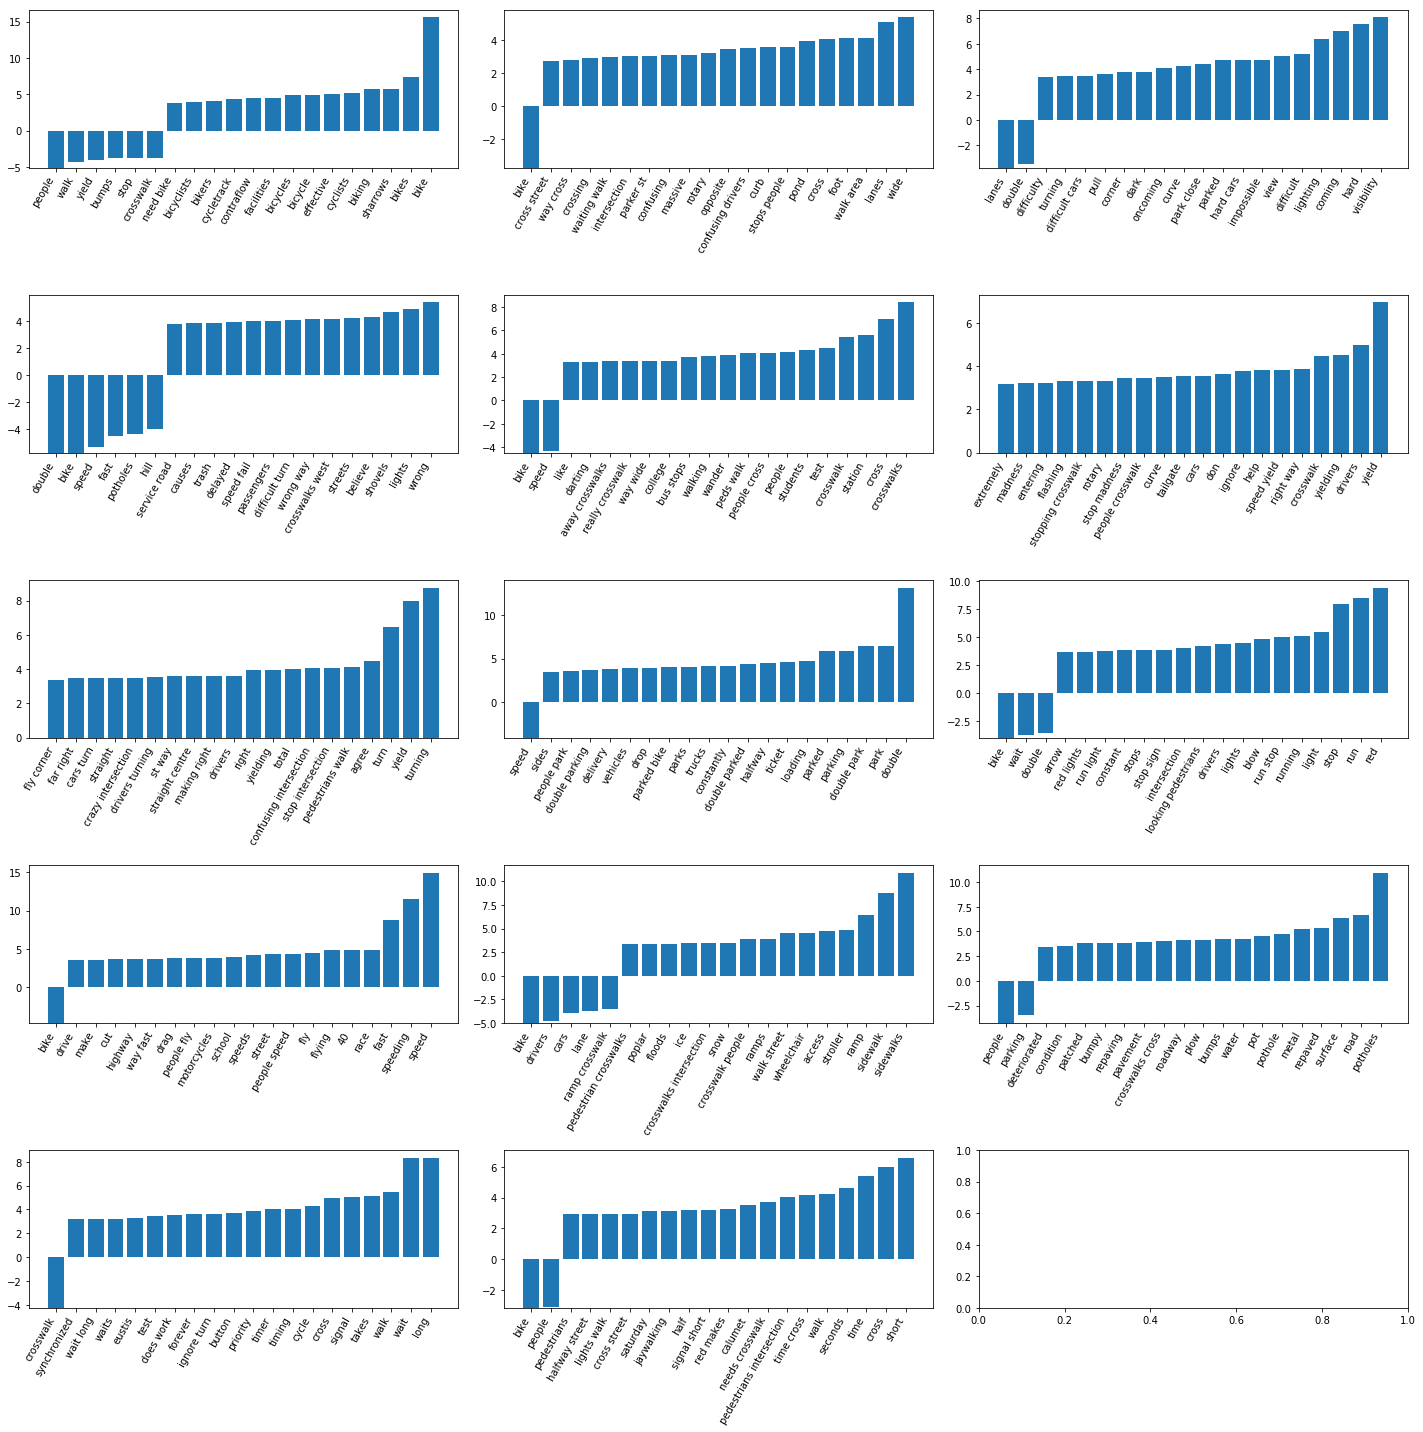

In [212]:
n_components = 20
fig, axes = plt.subplots(5, 3, figsize=(20, 20))
for ax, coef in zip(axes.ravel(), lr_grid.coef_):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()
plt.show()

In [159]:
# looking at wrong predictions
a = [i for i, x in enumerate(y_pred1!=y_test) if x]
df3 = text[a]
df1 = pd.DataFrame(y_test[y_pred1!=y_test])
df2 = pd.DataFrame(y_pred1[a])
#from astropy.table import Table, Column
#Table([df1,df2], names=('y_test','y_pred1'))

y_test [1],y_pred1 [1]
object,object
people speed,of something that is not listed here
of something that is not listed here,bike facilities don't exist or need improvement
people don't yield while going straight,of something that is not listed here
bike facilities don't exist or need improvement,of something that is not listed here
people don't yield while going straight,it’s hard to see / low visibility
people speed,of something that is not listed here
it's too far / too many lanes to cross,it’s hard to see / low visibility
it's too far / too many lanes to cross,people cross away from the crosswalks
of something that is not listed here,people run red lights / stop signs


###  Most wrong predictions relate to type 'of something that is not listed here', either in true request type or in the prediction. Because of high frequency of  'of something that is not listed here' in true request type, frequency of 'of something that is not listed here' in prediction is also high, which is not we want in the model. Further define in the request type 'of something that is not listed here' would help improve the model.

# Task5 - Clustering 

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

In [213]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import adjusted_rand_score
# grid search best ARI for logisticregression with NMF
# n_components=7
#for i in [2,3,4,5,6,7,8,9,10,11,12,13]:
#    pipe = make_pipeline(vect,MaxAbsScaler(),NMF(n_components=i, verbose=10, tol=0.01))
#    X_nmf = pipe.fit(text.values.astype('U'))
#    print(i,adjusted_rand_score(y, X_nmf.transform(text.values.astype('U')).argmax(axis=1)))
        

In [249]:
pipe_nmf = make_pipeline(vect,MaxAbsScaler(),NMF(n_components=7, verbose=10, tol=0.01))
X_nmf = pipe_nmf.fit_transform(text.values.astype('U'))
feature_names = np.array(vect.get_feature_names())
ari_nmf = adjusted_rand_score(y, X_nmf.argmax(axis=1))
print("ARI: {}".format(ari_nmf))

violation: 1.0
violation: 0.6386342986205985
violation: 0.3239064462301696
violation: 0.16800017619244195
violation: 0.10075637478262488
violation: 0.06796645638306746
violation: 0.049936130279118425
violation: 0.03954320587806392
violation: 0.03269297539700064
violation: 0.027780693721284576
violation: 0.02399822497185623
violation: 0.020885995622560924
violation: 0.018225489625386358
violation: 0.015875678590545436
violation: 0.01375906266186557
violation: 0.01188858382687808
violation: 0.010259106714144553
violation: 0.008855037300275181
Converged at iteration 18
ARI: 0.10550138174492477


In [215]:
from sklearn.decomposition import LatentDirichletAllocation
# grid search best ARI for logisticregression with LDA
# n_components=3
#for i in [2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
#    pipe = make_pipeline(vect,LatentDirichletAllocation(n_topics=i, learning_decay =.5))# learning_method="batch"))
#    X_lda = pipe.fit(text.values.astype('U'))
#    print(i,adjusted_rand_score(y, X_lda.transform(text.values.astype('U')).argmax(axis=1)))

In [216]:
pipe_lda = make_pipeline(vect,LatentDirichletAllocation(n_topics=3, learning_decay =.5))# learning_method="batch"))
X_lda = pipe_lda.fit_transform(text.values.astype('U'))
ari_lda = adjusted_rand_score(y, X_lda.argmax(axis=1))
print("ARI: {}".format(ari_lda))


/Users/sihui/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


ARI: 0.04374874466067256


In [217]:
from sklearn.cluster import KMeans
# grid search in KMeans
# 
#X = vect.fit_transform(text.values.astype('U'))
#for i in range(2,15,1):
#    kmean = KMeans(n_clusters=i)
#    print(adjusted_rand_score(y, clusters))

In [218]:
from sklearn.cluster import KMeans
pipe_kmean = make_pipeline(vect,KMeans(n_clusters=14))
X_kmean = pipe_kmean.fit_predict(text.values.astype('U'))
ari_kmean = adjusted_rand_score(y, X_kmean)
print("ARI: {}".format(ari_kmean))


ARI: 0.0668987420654331


In [219]:
print("NMF ARI: {}".format(ari_nmf), "LDA ARI: {}".format(ari_lda), "KMeans ARI: {}".format(ari_kmean))

NMF ARI: 0.10555090785507092 LDA ARI: 0.04374874466067256 KMeans ARI: 0.0668987420654331


### Based on grid search results of NMF, LDA and KMeans, we further look at the semantic meaning of clustering. NMF with n_components=7 gives great clusters, and highly matches with the ground truth, like 'people double park vehicles', 'bike facilities', and 'wait time for signal is too long'


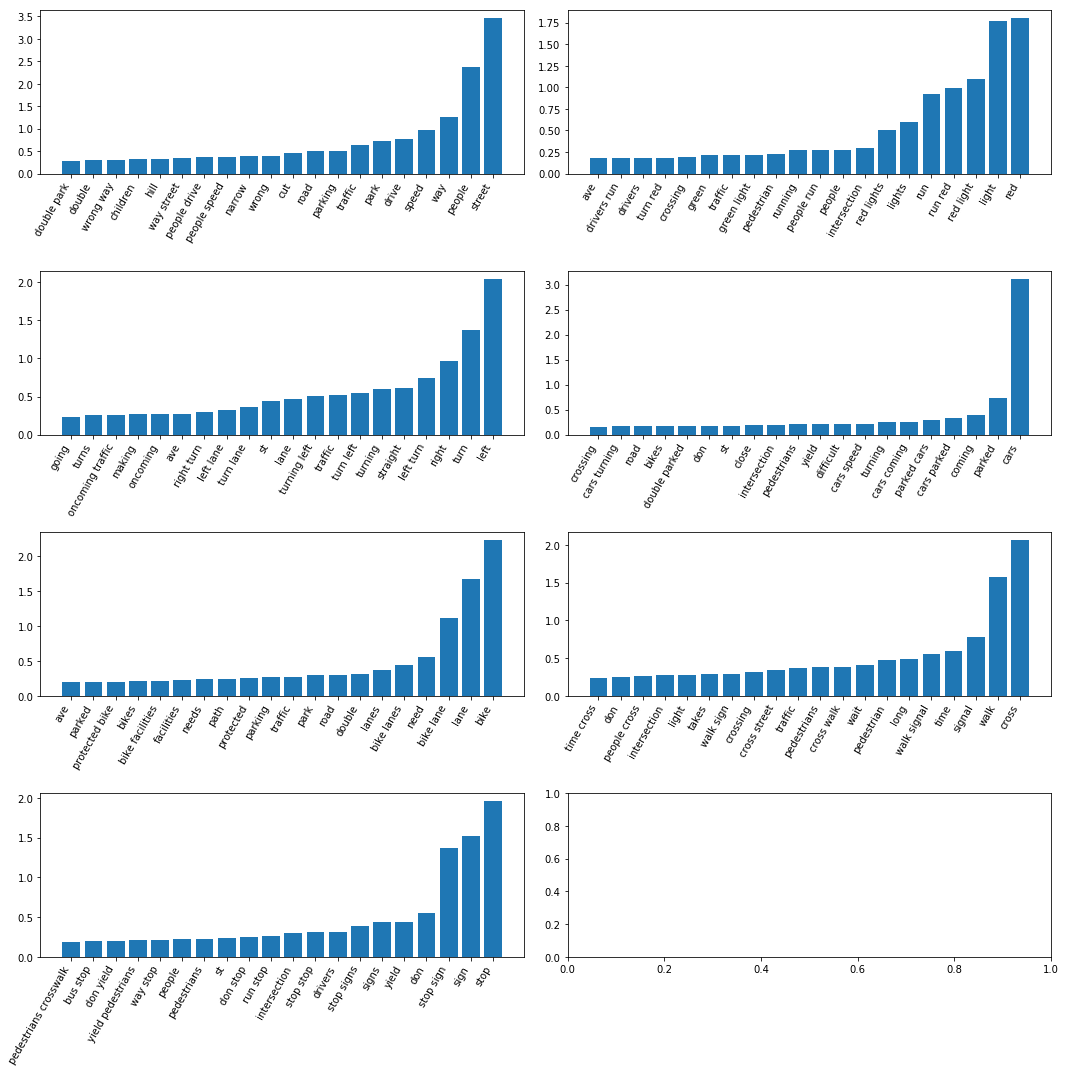

In [220]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
for ax, coef in zip(axes.ravel(), pipe_nmf.named_steps["nmf"].components_):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()
plt.show()


# Task6 - Model 3 

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


In [250]:
# use clustering in nmf(n_component=7) to re-assign request type
y_true = X_nmf.argmax(axis=1)

text_train, text_test, y_train_true, y_test_true = train_test_split(text, y_true, stratify=y_true, random_state=0)


In [251]:
#pipe = make_pipeline(TfidfVectorizer(stop_words='english'), LogisticRegression())
#param_grid={'logisticregression__C': [10, 1, .1, .01],
#            'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,5), (2,3)],
#            'tfidfvectorizer__min_df': [1,2,3,4],
#            'tfidfvectorizer__analyzer': ["word"],
#            'tfidfvectorizer__min_df': [2,3,4,5]}

#grid = GridSearchCV(pipe, param_grid=param_grid, cv=5,scoring='f1_macro')
#grid.fit(text_train.values.astype('U'), y_train_true)
#print("grid best score: {}".format(grid.best_score_))
#print("grid best parameters: {}".format(grid.best_params_))

In [252]:
vect = TfidfVectorizer(analyzer='word', ngram_range=(1,5), min_df=2)
X_train = vect.fit_transform(text_train.values.astype('U'))
X_test = vect.transform(text_test.values.astype('U'))

lr = LogisticRegression(C=10).fit(X_train, y_train_true)
print("best score: {}".format(lr.score(X_test, y_test_true)))

y_pred = lr.predict(X_test)
result = f1_score(y_test_true, y_pred,average='macro')
print("macro f1_score: {}".format(result))


best score: 0.8643962848297214
macro f1_score: 0.8650994774064912


### Based on NMF(n_components=6) in Task5, we re-assign request types as following:
- 0: people speed
- 1: people run red lights
- 2: drivers don't yield pedestrains when turning or going straight
- 3: people double park cars 
- 4: bike facilities don't exist or need improvement  
- 5: the wait for the "Walk" signal is too long
- 6: people run stop signs 

In [253]:
# re-assign other
other = df.loc[df['REQUESTTYPE'] == 'of something that is not listed here']
text_other = other['COMMENTS']
y_other = other['REQUESTTYPE']


violation: 1.0
violation: 0.6943327399602773
violation: 0.4381316287571951
violation: 0.32123713178595836
violation: 0.25680601460145164
violation: 0.22066295043875636
violation: 0.1993471468535085
violation: 0.18325663427150307
violation: 0.16343403412664326
violation: 0.13302325416113747
violation: 0.11546505738797364
violation: 0.10235731781867952
violation: 0.09012667733142173
violation: 0.07856820101837503
violation: 0.06420971443499979
violation: 0.054043425086037405
violation: 0.046885275259856765
violation: 0.04181211828306541
violation: 0.03846591803435045
violation: 0.03620133779384726
violation: 0.03487593844229117
violation: 0.03417346525497561
violation: 0.03391663682119081
violation: 0.0339119479881425
violation: 0.033930367450529665
violation: 0.034113312266135884
violation: 0.03447417249754918
violation: 0.034920164351487794
violation: 0.03540313994000055
violation: 0.03596042331714867
violation: 0.03651764178327452
violation: 0.037034254657952626
violation: 0.037643830

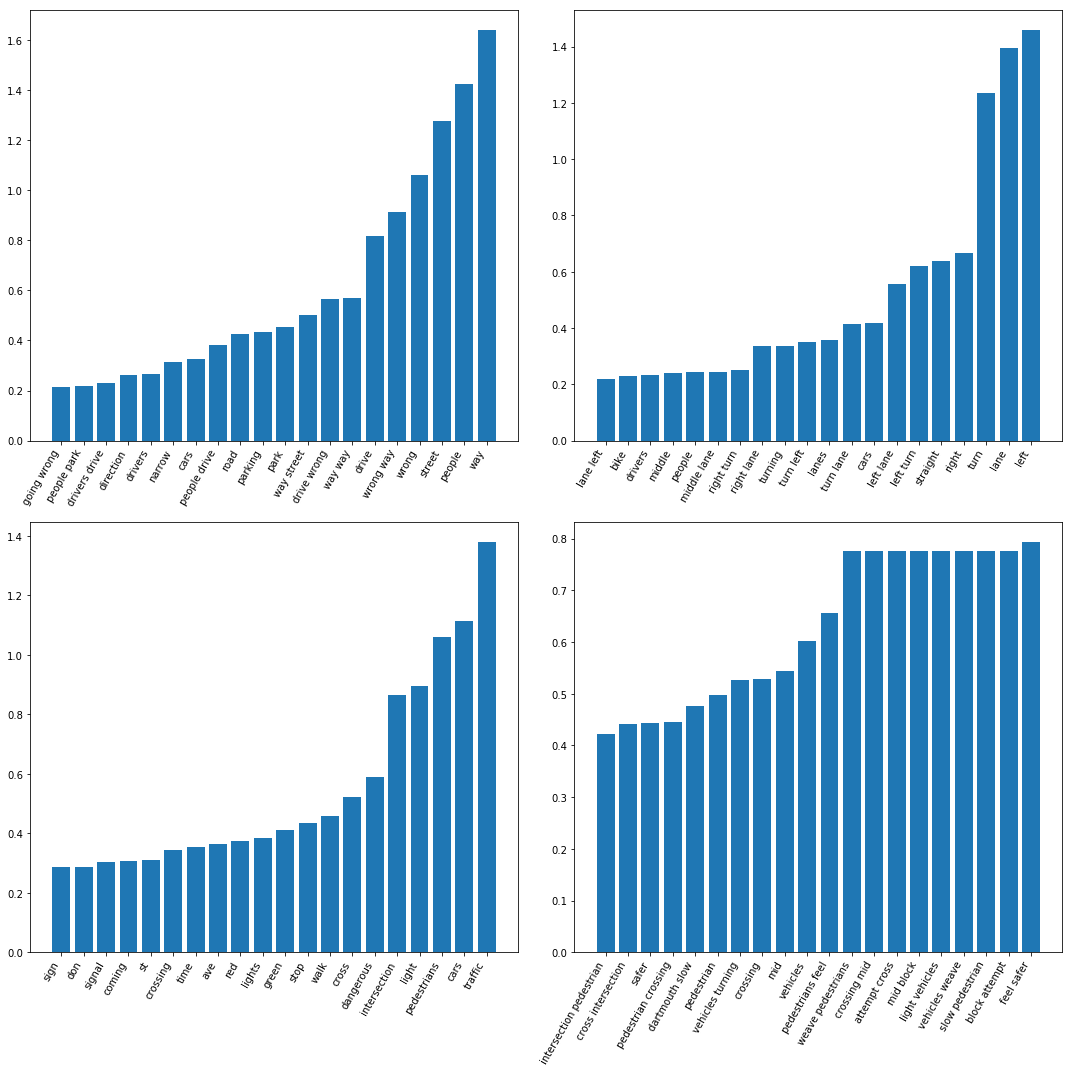

In [254]:
vect = TfidfVectorizer(stop_words='english', min_df = 2, ngram_range = (1,2), analyzer = 'word')
pip_nmf = make_pipeline(vect,MaxAbsScaler(),NMF(n_components=4, verbose=10, tol=0.01))
X_other_nmf = pip_nmf.fit_transform(text_other.values.astype('U'))
feature_names = np.array(vect.get_feature_names())

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for ax, coef in zip(axes.ravel(), pip_nmf.named_steps["nmf"].components_):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()
plt.show()

### Request type of 'of something not list here' can be re-assign as following types:
- 0: drive wrong way
- 1: drivers don't yield pedestrains when turning or going straight
- 2: people run stop signs / red lights
- 3: people / vehicles weave

In [255]:
assert result > .75


# Extra 

Use a word embedding representation like word2vec for step 3 and or step 6. 

In [256]:
#text = df['COMMENTS']
#y = df['REQUESTTYPE']
#text_train, text_test, y_train, y_test = train_test_split(text, y, stratify=y, random_state=1)

In [79]:
##from gensim import models
#w = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
## the package is too large to upload to github

2017-04-17 12:06:00,260 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2017-04-17 12:07:28,199 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


In [257]:
#vect_w2v = CountVectorizer(vocabulary=w.index2word)
#vect_w2v.fit(text_train)
#docs = vect_w2v.inverse_transform(vect_w2v.transform(text_train))

array(['in', 'on', 'the', 'at', 'all', 'people', 'day', 'open', 'times',
       'front', 'double', 'street', 'park', 'bar', 'parking', 'spots',
       'blocking', 'narrowing', 'english', 'tom', 'emerson'], 
      dtype='<U98')

In [258]:
#def read_corpus(text, tokens_only=False):
#    for i, line in enumerate(text):
#        if tokens_only:
#            yield gensim.utils.simple_preprocess(line)
#        else:
#            # For training data, add tags
#            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [259]:
#train_corpus = list(read_corpus(text_train))
#test_corpus = list(read_corpus(text_test, tokens_only=True))

In [260]:
#model = gensim.models.doc2vec.Doc2Vec(size=300, min_count=2, iter=55)
#model.build_vocab(train_corpus)

2017-04-17 15:00:10,499 : INFO : collecting all words and their counts
2017-04-17 15:00:10,504 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-17 15:00:10,571 : INFO : collected 5632 word types and 4842 unique tags from a corpus of 4842 examples and 118754 words
2017-04-17 15:00:10,573 : INFO : Loading a fresh vocabulary
2017-04-17 15:00:10,619 : INFO : min_count=2 retains 3191 unique words (56% of original 5632, drops 2441)
2017-04-17 15:00:10,621 : INFO : min_count=2 leaves 116313 word corpus (97% of original 118754, drops 2441)
2017-04-17 15:00:10,646 : INFO : deleting the raw counts dictionary of 5632 items
2017-04-17 15:00:10,662 : INFO : sample=0.001 downsamples 74 most-common words
2017-04-17 15:00:10,666 : INFO : downsampling leaves estimated 82021 word corpus (70.5% of prior 116313)
2017-04-17 15:00:10,673 : INFO : estimated required memory for 3191 words and 300 dimensions: 15064300 bytes
2017-04-17 15:00:10,708 : INFO : resetting layer

In [261]:
#model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)

2017-04-17 15:00:16,315 : INFO : training model with 3 workers on 3191 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2017-04-17 15:00:17,582 : INFO : PROGRESS: at 2.45% examples, 93111 words/s, in_qsize 6, out_qsize 0
2017-04-17 15:00:18,586 : INFO : PROGRESS: at 5.20% examples, 110021 words/s, in_qsize 6, out_qsize 0
2017-04-17 15:00:19,590 : INFO : PROGRESS: at 8.41% examples, 123174 words/s, in_qsize 5, out_qsize 0
2017-04-17 15:00:20,663 : INFO : PROGRESS: at 10.55% examples, 116206 words/s, in_qsize 5, out_qsize 0
2017-04-17 15:00:21,675 : INFO : PROGRESS: at 12.24% examples, 109217 words/s, in_qsize 5, out_qsize 0
2017-04-17 15:00:22,834 : INFO : PROGRESS: at 14.67% examples, 107721 words/s, in_qsize 6, out_qsize 1
2017-04-17 15:00:23,871 : INFO : PROGRESS: at 18.04% examples, 114208 words/s, in_qsize 6, out_qsize 0
2017-04-17 15:00:24,888 : INFO : PROGRESS: at 21.41% examples, 119382 words/s, in_qsize 6, out_qsize 0
2017-04-17 15:00:25,976 : INFO 

4777328

In [262]:
#import pickle
#with open("doc2vec_300.pickle", "wb") as f:
#    pickle.dump(model, f, -1)

In [263]:
#vectors = [model.infer_vector(train_corpus[doc_id].words)
#          for doc_id in range(len(train_corpus))]

In [264]:
#X_train = np.vstack(vectors)
#X_train.shape
#test_vectors = [model.infer_vector(test_corpus[doc_id])
#                for doc_id in range(len(test_corpus))]
#X_val = np.vstack(test_vectors)
#from sklearn.linear_model import LogisticRegression
#lr = LogisticRegression(C=100).fit(X_train, y_train)

In [266]:
#lr.score(X_train, y_train)

0.3903345724907063

In [271]:
#lr.score(X_val, y_test)

0.29287925696594425

In [270]:
#from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier(n_estimators=500, max_depth=8).fit(X_train, y_train)
#rf.score(X_train, y_train)

0.42709624122263529

In [272]:
#rf.score(X_val, y_test)

0.2371517027863777